In [148]:
import numpy as np
import scipy.integrate
import scipy.interpolate
%matplotlib inline
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.lines as mlines
import glob
import operator as op

from __future__ import print_function, division

mpl.rc('font', size=18)
mpl.rc('figure', figsize=(12,6))
mpl.rc('figure', autolayout=False)
mpl.rc('text', usetex=False)

In [2]:
# convert a string representation of a number
# of the sort produced by spherical_cloudy
# back into a numerical value, by replacing:
#     'd' with '.'
#     'p' with '+'
#     'n' with '-'
def deformat_string(s):
    return s.replace('d', '.').replace('p', '+').replace('m', '-')

ions = ['H I', 'D I', 'He I', 'He II']
nions = len(ions)

sph_cloudy_dtype = ([('rad', 'float64'),           # radius
                     ('temp', 'float64'),          # temperature
                     ('masspp', 'float64'),        # mean particle mass
                     ('hden', 'float64'),          # HI volume density
                     ('HaSB', 'float64'),          # surface brightness in H-alpha
                     ('vden', 'float64', nions),   # volume density for each species
                     ('cden', 'float64', nions)])  # column density for each species

class SphCloudyResult:
    def __init__(self, fname):
        self.fname = fname
        self.data = np.load(fname)
        self.data.dtype = sph_cloudy_dtype
        
        # parse the file name to extract model parameters
        self.params = dict()
        end_of_rel_path = fname.rfind('/') + 1
        fname_parts = fname[end_of_rel_path:].split('_')
        for part in fname_parts:
            if(part == 'NFW'):
                self.params['profile'] = 'NFW'
            elif part.startswith('mass'):
                mass_str = deformat_string(part[4:])
                self.params['mass'] = float(mass_str)
            elif part.startswith('redshift'):
                z_str = deformat_string(part[8:])
                self.params['redshift'] = float(z_str)
            elif part.startswith('baryscl'):
                bary_str = deformat_string(part[7:])
                self.params['bary_scl'] = float(bary_str)
            elif part.startswith('HMscale'):
                He_str = deformat_string(part[7:])
                self.params['HM_scl'] = float(He_str)
            else:
                # remaining part is nrad_nmu (.npy)
                nrad, nmu = (part.rstrip('.npy').split('-'))
                self.params['n_rad'] = nrad
                self.params['nmu'] = nmu

## Load data from spherical_cloudy

In [187]:
sph_cloudy_files = glob.glob('../output/force_nHT/NFW*.npy')
sph_cloudy_data = [SphCloudyResult(f) for f in sph_cloudy_files]

def compose(f, g):
    return lambda x: f(g(x))

nvalues = 1000
nhaloes = len(sph_cloudy_data)

sorted_by_mass = sorted(sph_cloudy_data, key=compose(op.itemgetter('mass'),op.attrgetter('params')))
sph_cloudy_masses = 10**np.array(list(map(compose(op.itemgetter('mass'),op.attrgetter('params')), sorted_by_mass)))
sph_cloudy_radii = np.array([res.data['rad'] for res in sorted_by_mass]).reshape(nhaloes, nvalues)
sph_cloudy_lognh = np.log10([res.data['hden'] for res in sorted_by_mass]).reshape(nhaloes, nvalues)
sph_cloudy_logT = np.log10([res.data['temp'] for res in sorted_by_mass]).reshape(nhaloes, nvalues)
sph_cloudy_mu = np.array([res.data['masspp'] for res in sorted_by_mass]).reshape(nhaloes, nvalues)
sph_cloudy_cd = np.array([res.data['cden'] for res in sorted_by_mass]).reshape(nhaloes, nvalues, nions)
sph_cloudy_vd = np.array([res.data['vden'] for res in sorted_by_mass]).reshape(nhaloes, nvalues, nions)

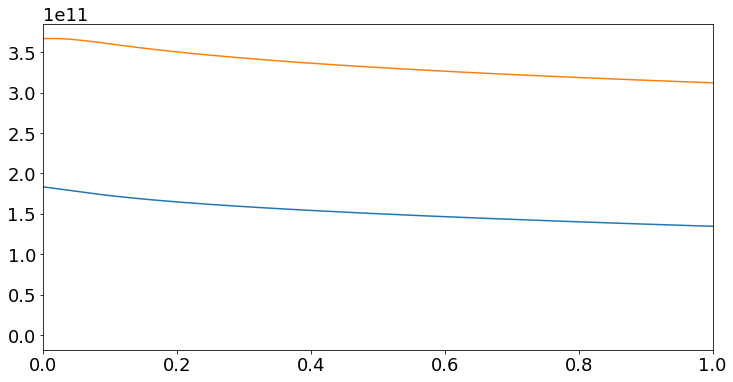

In [198]:
cm_per_pc = 3e10 * 86400 * 365 * 3.26
solmass = 1.990e33
rho200 = 200 * 8.46543558829e-30

which = 0

# mu = 1 (ie theta = 0)

r200 = lambda m200: (3 * m200 * solmass / (4 * np.pi * rho200))**(1/3)
R200s = r200(sph_cloudy_masses)

def func(r, rmin, n, mu):
    #%pdb
    #assert r**2 > rmin**2 * (1 - mu**2)
    return (r * n) / np.sqrt(r**2 - rmin**2 * (1 - mu**2))

def coldens(radius, density, mu):
    ret = np.zeros_like(radius)
    #func = lambda r, n: (r * n) / np.sqrt(r**2 - rmin**2 * (1 - mu**2))
    if mu < 0:
        raise ValueError('Not implemented!')
        #for idx, rmin in enumerate(radius):
        #    rg1 = np.logical_and(radius > (rmin * np.sqrt(1 - mu**2)), radius < rmin)
        #    rg2 = np.logical_and(radius < (rmin * np.sqrt(1 - mu**2)), radius < R200s[which])
        #    ret[idx] = (scipy.integrate.trapz(func(radius[rg1], rmin, density[rg1], mu), radius[rg1]) if rg1.any() == True else 0 +
        #                scipy.integrate.trapz(func(radius[rg2], rmin, density[rg2], mu), radius[rg2]) if rg2.any() == True else 0)
    else:
        for idx, rmin in enumerate(radius):
            rg = radius > rmin
            ret[idx] = scipy.integrate.trapz(func(radius[rg], rmin, density[rg], mu), radius[rg])
    return ret

plt.xlim(0,1)
plt.plot((sph_cloudy_radii[which])*cm_per_pc/R200s[which], coldens(sph_cloudy_radii[which] * cm_per_pc, sph_cloudy_vd[which,:,0], 1));
plt.plot((sph_cloudy_radii[which])*cm_per_pc/R200s[which], sph_cloudy_cd[which,:,0]);